In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First of all, we get the data from csv file. (expected return and covariance matrix)

In [30]:
Eret = pd.read_csv("expected_return.csv").values
covariance = pd.read_csv("covariance_matrix.csv").values

We are looking to minimize the function:

$$ x^TCx - \beta x^T\mu$$

which $x^T$ is x array, C is the covariance matrix and $\mu$ is the Eret.

In [31]:
def cost_func(x, beta):
    return x@covariance@np.transpose(x) - beta*(x*Eret).sum()

First of all, we get the data from csv file. (expected return and covariance matrix)

In [32]:
def check(arr):
    normalized_arr = [max(0, float(element)) for element in arr]
    new_sum = sum(normalized_arr)
    normalized_arr = [element/new_sum for element in normalized_arr]
    return np.array(normalized_arr)

This is the selection function. We use tournament selection for this algorithm.

In tournament selection, we randomly pick 5 array from population and return the one that has the lowest cost.

In [33]:
def tournament_selection(population, beta):
    m = 1000
    for i in range(5):
        random_index = np.random.randint(len(population))
        cost = cost_func(population[random_index], beta)
        if (cost < m):
            m = cost
            arr = population[random_index]
    return arr

crossover:

We use a random alpha and build two children like this:
$$ c_1(i) = alpha\times (p_1(i) + p_2(i))$$
$$ c_2(i) = (1-alpha)\times (p_1(i) + p_2(i)) $$

In [34]:
def crossover(x, y):
    alpha = np.random.rand(1)
    
    c1 = np.zeros(10)
    c2 = np.zeros(10)
    
    for i in range(10):
        c1[i] = alpha*(x[i] + y[i])
        c2[i] = (1-alpha)*(x[i] + y[i])
        
    return c1, c2

In mutation, we pick a random number of indexes from 1 to 8 and then give that index, a random number between 0 and 0.5

In [35]:
def mutation(x):
    num = np.random.randint(8)
    for i in range(num):
        random_index = np.random.randint(10)
        x[random_index] = np.random.uniform(0, 0.5)
    return x

In this function, we sort ascending two array based on the first one (x).

In [36]:
def double_sort(x, y):
    for i in range(len(x)):
        for j in range(i, len(x)):
            if (x[j] < x[i]):
                x[i], x[j] = x[j], x[i]
                y[i], y[j] = y[j].copy(), y[i].copy()
    return x, y

this is the particle class for PSO algorithm

In [37]:
class particle:
    def __init__(self, arr, vel):
        self.pos = np.array(arr)
        self.best_pos = self.pos
        self.velocity = np.array(vel)

PSO algorithm which is exactly the one that we used for PSO alone itself.

In [38]:
def PSO_on_population(population, iterations, c_1, c_2, w, beta):
    np.random.seed(100)
    
    n = len(population)
    particles = [particle(population[i], [np.random.uniform(-0.5, 0.5) for i in range(10)]) for i in range(n)] #part A
    costs = [cost_func(particles[i].pos, beta) for i in range(n)]
    
    for i in range(n):
        particles[i].pos = check(particles[i].pos)
    
    minimum = 1000
    min_i = 0
    for i in range(n):
        if (minimum > costs[i]):
            minimum = costs[i]
            min_i = i
            
    best_global_index = min_i
    best_fitness = minimum
    best_final = particles[best_global_index].pos
    
    best = []
    
    for it in range(iterations):
        for i in range(n):
            particles[i].velocity = w*particles[i].velocity + c_1*np.random.rand(1)*(particles[best_global_index].best_pos - particles[i].pos) + c_2*np.random.rand(1)*(particles[i].best_pos - particles[i].pos)
            
            particles[i].pos = particles[i].pos + particles[i].velocity
                
            particles[i].pos = check(particles[i].pos)
            
            if (cost_func(particles[i].pos, beta) < cost_func(particles[i].best_pos, beta)):
                particles[i].best_pos = particles[i].pos
                
            if (cost_func(particles[i].pos, beta) < cost_func(particles[best_global_index].best_pos, beta)):
                best_global_index = i
            
            if (cost_func(particles[i].pos, beta) < minimum):
                best_final = particles[best_global_index].pos
                minimum = cost_func(particles[best_global_index].pos, beta)
                
        best.append(cost_func(particles[best_global_index].best_pos, beta))
        
    return np.array([particles[i].pos for i in range(n)])

This is the main algorithm

>first of all, we make the initial population

>then for iteration times:

first use the PSO algorithm to make the population a bit better.

then by choosing the parents and making children, build the new population.
children and maid by crossover and mutation on chosen parents.

>each time, find the best and store the cost.

In [39]:
def genetic_PSO(n, iterations, mutation_chance, crossover_chance, replace_rate, PSO_iterations, c_1, c_2, w, beta):
    np.random.seed(100)
    
    population = np.array([[np.random.uniform(0, 1) for i in range(10)] for i in range(n)])
    
    for i in range(n):
        population[i] = check(population[i])
            
    cost_array = np.array([cost_func(population[i], beta) for i in range(n)])
    
    min_cost = 1000
    for i in range(len(cost_array)):
        if (cost_array[i] < min_cost):
            min_cost = cost_array[i]
            min_array = population[i]
    
    best_generation = np.array([])
            
    for i in range(iteration):
        child = np.empty((0, 10))
        
        population = PSO_on_population(population, PSO_iterations, 10*c_1/(i+1), 10*c_2/(i+1), 10*w/(i+1), beta)
        cost_array = np.array([cost_func(population[j], beta) for j in range(n)])
        
        for k in range(n//2):
            p1 = tournament_selection(population, beta)
            p2 = tournament_selection(population, beta)
    
            chance = np.random.rand()
            if (chance <= crossover_chance):
                c1, c2 = crossover(p1, p2)
            else:
                c1, c2 = p1, p2
                
            chance = np.random.rand()
            if (chance <= mutation_chance): 
                c1 = mutation(c1)
                c2 = mutation(c2)
            
            child = np.concatenate((child, [check(c1)]))
            child = np.concatenate((child, [check(c2)]))
            
        cost_child = np.array([cost_func(child[j], beta) for j in range(n)])
        cost_array, population = double_sort(cost_array, population)
        cost_child, child = double_sort(cost_child, child)
        
        population = np.concatenate((population[:int(replace_rate*n)], child[:int((1-replace_rate)*n)]), axis=0)
        cost_array = np.append(cost_array[:int(replace_rate*n)], cost_child[:int((1-replace_rate)*n)])
        
        best_index = np.where(cost_array == min(cost_array))[0][0]
        best = cost_array[best_index]
        last_array = population[best_index]
        best_generation = np.append(best_generation, best)
        
        if (best < min_cost):
            min_cost = best
            min_array = population[best_index]
            
    return best_generation, min_array, last_array
        

And Finally a test for our algorithm:

In [40]:
iteration = 5000
arr, best_pos, last_pos = genetic_PSO(100, iteration, 0.6, 0.95, 0.6, 20, 0.8, 0.3, 0.2, 100) #n, iterations, mutation_chance, replace_rate, PSO_iterations, c_1, c_2, w, beta

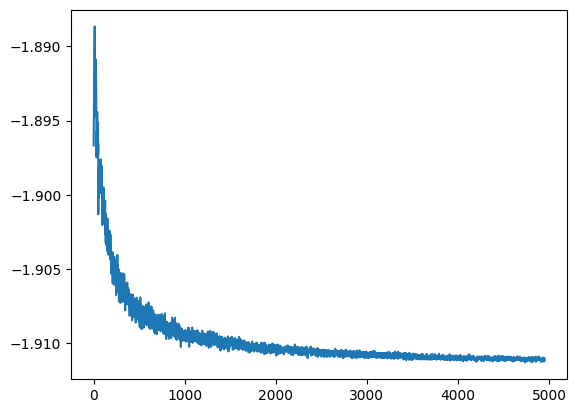

In [46]:
ite = [i+1 for i in range(iteration)]
plt.plot(ite, arr)
plt.show()

In [42]:
print(best_pos)
print(last_pos)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[2.93655294e-04 1.26553358e-05 5.39843631e-05 0.00000000e+00
 7.00495986e-05 0.00000000e+00 0.00000000e+00 9.99528974e-01
 3.98133540e-05 8.67880045e-07]


In [43]:
print((best_pos*Eret).sum())
print((last_pos*Eret).sum())

0.0192179245283018
0.019213552686346842


In [44]:
print(best_pos@covariance@np.transpose(best_pos))
print(last_pos@covariance@np.transpose(last_pos))

0.0101622232692307
0.010157841311674558


In [45]:
print(best_pos.sum())
print(last_pos.sum())

1.0
1.0
